In [1]:
# Use seaborn for pairplot
#!sudo pip install -q seaborn

# Use some functions from tensorflow_docs
#!sudo pip install -q git+https://github.com/tensorflow/docs

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/jupyter/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

In [9]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
dataset['Origin'].head()

0    USA
1    USA
2    USA
3    USA
4    USA
Name: Origin, dtype: object

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
dataset[['Cylinders', 'Model Year']].describe()

,Cylinders,Model Year
count,392.000000,392.000000
mean,5.471939,75.979592
std,1.705783,3.683737
min,3.000000,70.000000
25%,4.000000,73.000000
50%,4.000000,76.000000
75%,8.000000,79.000000
max,8.000000,82.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62e7607a20>]],
      dtype=object)

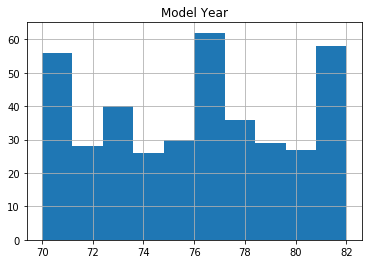

In [12]:
dataset[['Model Year']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62e5543ba8>]],
      dtype=object)

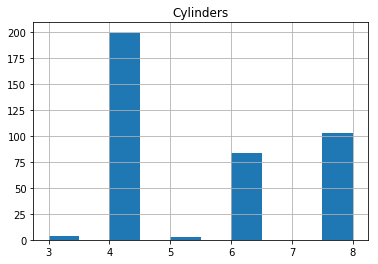

In [13]:
dataset[['Cylinders']].hist()

In [14]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [15]:
print(train_dataset.shape)
print(test_dataset.shape)

(314, 10)
(78, 10)


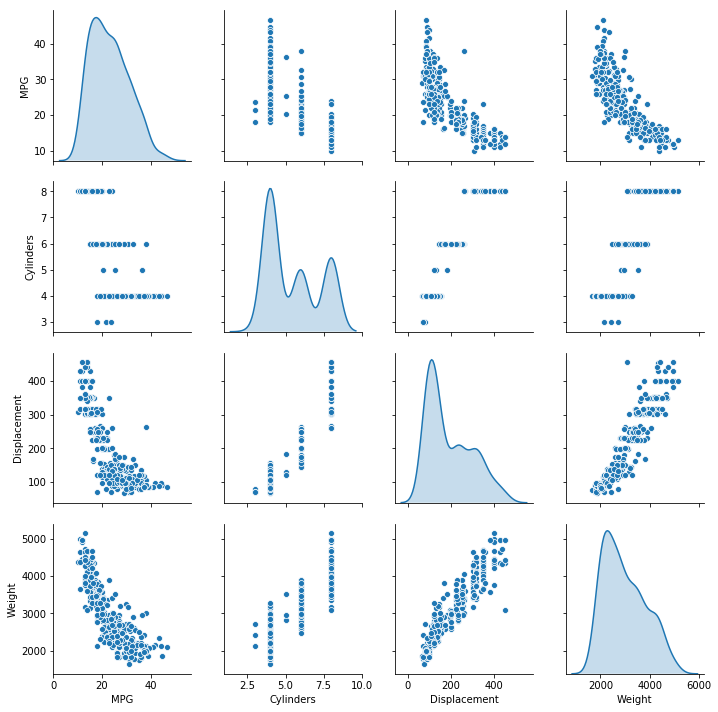

In [16]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [17]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [18]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [19]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [36]:
 train_stats['mean']

Cylinders          5.477707
Displacement     195.318471
Horsepower       104.869427
Weight          2990.251592
Acceleration      15.559236
Model Year        75.898089
Europe             0.178344
Japan              0.197452
USA                0.624204
Name: mean, dtype: float64

In [20]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [21]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [22]:
model = build_model()

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.predict(normed_train_data[:10])

array([[-0.00601224],
       [-0.0826565 ],
       [-0.12514283],
       [-0.25111893],
       [-0.24199905],
       [-0.27104893],
       [-0.27652806],
       [-0.22797011],
       [-0.12961498],
       [-0.1874237 ]], dtype=float32)

In [25]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:576.2221,  mae:22.6802,  mse:576.2221,  val_loss:571.2424,  val_mae:22.4901,  val_mse:571.2424,  
....................................................................................................
Epoch: 100, loss:6.0885,  mae:1.7222,  mse:6.0885,  val_loss:7.9176,  val_mae:2.0440,  val_mse:7.9176,  
....................................................................................................
Epoch: 200, loss:5.3184,  mae:1.6059,  mse:5.3184,  val_loss:7.4004,  val_mae:2.0611,  val_mse:7.4004,  
....................................................................................................
Epoch: 300, loss:5.1548,  mae:1.5745,  mse:5.1548,  val_loss:7.4362,  val_mae:2.0443,  val_mse:7.4362,  
....................................................................................................
Epoch: 400, loss:4.5408,  mae:1.4303,  mse:4.5408,  val_loss:7.5472,  val_mae:2.0628,  val_mse:7.5472,  
..............................................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.322399,1.001872,2.322398,8.749469,2.344174,8.749469,995
996,2.306111,0.980396,2.306111,8.698159,2.272441,8.698159,996
997,2.405062,1.020060,2.405062,8.278281,2.251240,8.278281,997
998,2.322191,0.972397,2.322191,8.449203,2.287574,8.449203,998
999,2.449212,0.995932,2.449212,7.750340,2.171019,7.750340,999


In [38]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 1000,
 'metrics': ['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'],
 'samples': 251,
 'steps': 8,
 'verbose': 0}

In [27]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [39]:
?plotter

Type:        HistoryPlotter
String form: <tensorflow_docs.plots.HistoryPlotter object at 0x7f62e40d34a8>
File:        /usr/local/lib/python3.5/dist-packages/tensorflow_docs/plots/__init__.py
Docstring:  
A class for plotting named set of keras-histories.

The class maintains colors for each key from plot to plot.


Text(0, 0.5, 'MAE [MPG]')

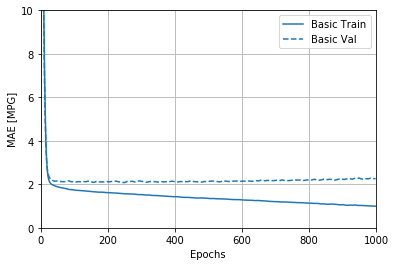

In [28]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

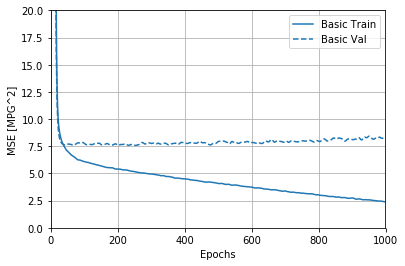

In [29]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [30]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:581.6139,  mae:22.8428,  mse:581.6138,  val_loss:574.1554,  val_mae:22.6541,  val_mse:574.1554,  
.....................................................................

Text(0, 0.5, 'MAE [MPG]')

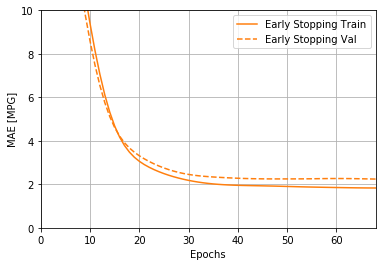

In [31]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.0954 - mae: 1.9119 - mse: 6.0954
Testing set Mean Abs Error:  1.91 MPG


In [33]:
test_predictions = model.predict(normed_test_data).flatten()

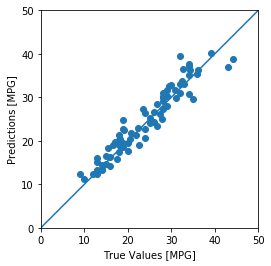

In [34]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


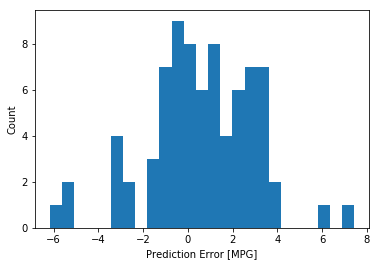

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")